In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
import re
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/ML_Assignment6/ML_A6_Q2_data.txt', delimiter = '\t', quoting = 3, header = None)

In [ ]:
dataset = dataset.sample(frac = 1, random_state=1).reset_index(drop = False)

In [ ]:
dataset.drop(['index'], axis = 1)

,0,1
0,"By the time the film ended, I not only dislike...",0
1,"The acting, as you'd expect from this cast, is...",1
2,"The plot doesn't hang together at all, and the...",0
3,I felt as though her going to Ireland did abso...,0
4,"If good intentions made a film great, then thi...",1
...,...,...
995,I am so tired of clichés that is just lazy wri...,0
996,"It crackles with an unpredictable, youthful en...",0
997,This is one of the worst Sandra Bullock movie ...,0
998,It was just too horrible.,0


# Preprocessing

## Lower Case

In [ ]:
def capital_to_lower(x):
  x=x.lower()
  return x

In [ ]:
dataset['lowercase'] = dataset.apply(lambda row: capital_to_lower(row[0]), axis=1)

In [ ]:
dataset

,index,0,1,lowercase
0,507,"By the time the film ended, I not only dislike...",0,"by the time the film ended, i not only dislike..."
1,818,"The acting, as you'd expect from this cast, is...",1,"the acting, as you'd expect from this cast, is..."
2,452,"The plot doesn't hang together at all, and the...",0,"the plot doesn't hang together at all, and the..."
3,368,I felt as though her going to Ireland did abso...,0,i felt as though her going to ireland did abso...
4,242,"If good intentions made a film great, then thi...",1,"if good intentions made a film great, then thi..."
...,...,...,...,...
995,767,I am so tired of clichés that is just lazy wri...,0,i am so tired of clichés that is just lazy wri...
996,72,"It crackles with an unpredictable, youthful en...",0,"it crackles with an unpredictable, youthful en..."
997,908,This is one of the worst Sandra Bullock movie ...,0,this is one of the worst sandra bullock movie ...
998,235,It was just too horrible.,0,it was just too horrible.


## Remove punctuations

In [ ]:
def remove_punctuation(x):
    words=word_tokenize(x)
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
        
    x=' '.join(new_words)  
    return x

In [ ]:
dataset['Rem_punc'] = dataset.apply(lambda row: remove_punctuation(row['lowercase']), axis=1)

In [ ]:
dataset

,index,0,1,lowercase,Rem_punc
0,507,"By the time the film ended, I not only dislike...",0,"by the time the film ended, i not only dislike...",by the time the film ended i not only disliked...
1,818,"The acting, as you'd expect from this cast, is...",1,"the acting, as you'd expect from this cast, is...",the acting as you d expect from this cast is t...
2,452,"The plot doesn't hang together at all, and the...",0,"the plot doesn't hang together at all, and the...",the plot does nt hang together at all and the ...
3,368,I felt as though her going to Ireland did abso...,0,i felt as though her going to ireland did abso...,i felt as though her going to ireland did abso...
4,242,"If good intentions made a film great, then thi...",1,"if good intentions made a film great, then thi...",if good intentions made a film great then this...
...,...,...,...,...,...
995,767,I am so tired of clichés that is just lazy wri...,0,i am so tired of clichés that is just lazy wri...,i am so tired of clichés that is just lazy wri...
996,72,"It crackles with an unpredictable, youthful en...",0,"it crackles with an unpredictable, youthful en...",it crackles with an unpredictable youthful ene...
997,908,This is one of the worst Sandra Bullock movie ...,0,this is one of the worst sandra bullock movie ...,this is one of the worst sandra bullock movie ...
998,235,It was just too horrible.,0,it was just too horrible.,it was just too horrible


## Stopwords

In [ ]:
def rem_stopwords(x):
  word_tokens = word_tokenize(x) 
  filtered_sentence = []   
  for w in word_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w) 
  return filtered_sentence

In [ ]:
dataset['Tokenized_tweets'] = dataset.apply(lambda row: rem_stopwords(row['Rem_punc']), axis=1)

In [ ]:
dataset

,index,0,1,lowercase,Rem_punc,Tokenized_tweets
0,507,"By the time the film ended, I not only dislike...",0,"by the time the film ended, i not only dislike...",by the time the film ended i not only disliked...,"[time, film, ended, disliked, despised]"
1,818,"The acting, as you'd expect from this cast, is...",1,"the acting, as you'd expect from this cast, is...",the acting as you d expect from this cast is t...,"[acting, expect, cast, top, notch]"
2,452,"The plot doesn't hang together at all, and the...",0,"the plot doesn't hang together at all, and the...",the plot does nt hang together at all and the ...,"[plot, nt, hang, together, acting, absolutely,..."
3,368,I felt as though her going to Ireland did abso...,0,i felt as though her going to ireland did abso...,i felt as though her going to ireland did abso...,"[felt, though, going, ireland, absolutely, not..."
4,242,"If good intentions made a film great, then thi...",1,"if good intentions made a film great, then thi...",if good intentions made a film great then this...,"[good, intentions, made, film, great, film, mi..."
...,...,...,...,...,...,...
995,767,I am so tired of clichés that is just lazy wri...,0,i am so tired of clichés that is just lazy wri...,i am so tired of clichés that is just lazy wri...,"[tired, clichés, lazy, writing, come, thick, f..."
996,72,"It crackles with an unpredictable, youthful en...",0,"it crackles with an unpredictable, youthful en...",it crackles with an unpredictable youthful ene...,"[crackles, unpredictable, youthful, energy, ho..."
997,908,This is one of the worst Sandra Bullock movie ...,0,this is one of the worst sandra bullock movie ...,this is one of the worst sandra bullock movie ...,"[one, worst, sandra, bullock, movie, since, sp..."
998,235,It was just too horrible.,0,it was just too horrible.,it was just too horrible,[horrible]


# Glove

 Unique Words

In [ ]:
dct=dict()
for x in dataset['Tokenized_tweets']:
  #y=nltk.word_tokenize(x)
  for wt in x:
    if wt not in dct:  
      dct[wt]=1
    else: 
       dct[wt]+=1

In [ ]:
input_len=len(dct)
input_len

2981

In [ ]:
# unigram_lst = dct.keys()
# unigram_lst = list(unigram_lst)
# len(unigram_lst)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_obj=Tokenizer(num_words=input_len)
tokenizer_obj.fit_on_texts(list(dataset['Tokenized_tweets']))
sequence = tokenizer_obj.texts_to_sequences(list(dataset['Tokenized_tweets']))
wrd_index = tokenizer_obj.word_index

 Maximum length sentence

In [ ]:
max_length=0
c=0
for x in sequence:
  c+=1
  if len(x)>max_length:
    max_length=len(x)
print(max_length)

41


Padding

In [ ]:
dataset_padded=pad_sequences(sequence,maxlen=max_length,padding="post")

In [ ]:
dataset_padded.shape

(1000, 41)

Glove

In [ ]:
file = open('/content/drive/MyDrive/ML_Assignment6/glove.6B.50d.txt')

In [ ]:
#file = open('/content/drive/MyDrive/NLP Project/glove.42B.300d.txt')

In [ ]:
model = dict()
for line in file:
  splitLine = line.split()
  word = splitLine[0]
  embedding = np.asarray(splitLine[1:], dtype='float32')
  model[word] = embedding
file.close()  

Embedding Matrix

In [ ]:
embedding_matrix = np.random.random((input_len + 1, 50))
for word,index in wrd_index.items():
  vec = dct.get(word)
  if vec is not None:
    embedding_matrix[index] = vec

In [ ]:
# import joblib
# joblib.dump(embedding_matrix,'/content/drive/MyDrive/ML_Assignment6/embedding_matrix')
# embedding_matrix = joblib.load('/content/drive/MyDrive/ML_Assignment6/embedding_matrix')

In [ ]:
embedding_matrix.shape

(2982, 50)

# Train test split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
S_train, S_test, L_train, L_test = train_test_split( dataset_padded, dataset[1], test_size=0.3, random_state=42)

# RNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,SimpleRNN, Activation,Bidirectional,SpatialDropout1D, MaxPooling1D, Conv1D

In [ ]:
model = keras.Sequential()
model.add(Embedding(input_len+1, 50,input_length=max_length, weights=[embedding_matrix]))
model.add(SimpleRNN(100, return_sequences=True))
model.add(SimpleRNN(100, return_sequences=True))
#model.add(layers.Flatten())
#model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 50)            149100    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 41, 100)           15100     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 41, 100)           20100     
_________________________________________________________________
dense_2 (Dense)              (None, 41, 1)             101       
Total params: 184,401
Trainable params: 184,401
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
loss,acc = model.evaluate(S_test,L_test)

10/10 [==============================] - 0s 7ms/step - loss: 0.9423 - accuracy: 0.6250


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
history_b=model.fit(S_train,L_train, batch_size=64, epochs=30,validation_data=(S_test,L_test))

In [ ]:
#model.save('/content/drive/MyDrive/MLAssignment6/model_2.sav')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/MLAssignment6/model_2.sav/assets


In [ ]:
model_glove = tf.keras.models.load_model('/content/drive/My Drive/MLAssignment6/model_2.sav')

In [ ]:
#np.save('/content/drive/My Drive/MLAssignment6/glove_history.npy', model.history.history)

In [ ]:
history_b = np.load('/content/drive/MyDrive/MLAssignment6/glove_history.npy',allow_pickle=True).item()

In [ ]:
model_glove.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 50)            149100    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 41, 100)           15100     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 41, 100)           20100     
_________________________________________________________________
dense_2 (Dense)              (None, 41, 1)             101       
Total params: 184,401
Trainable params: 184,401
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Accuracy Curves')

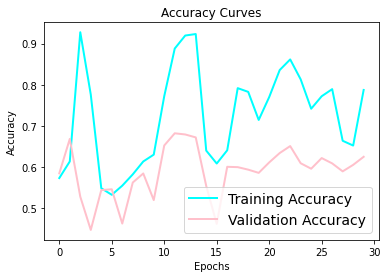

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(history_b['accuracy'], 'cyan', linewidth=2.0)
plt.plot(history_b['val_accuracy'], 'pink', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

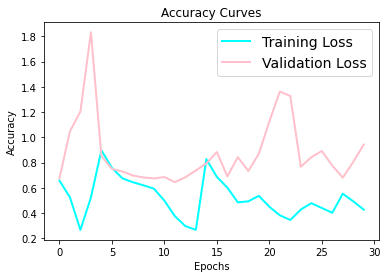

In [ ]:
plt.figure(figsize=[6,4])
plt.plot(history_b['loss'], 'cyan', linewidth=2.0)
plt.plot(history_b['val_loss'], 'pink', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)